In [1]:
import numpy as np
import scipy as sp
from pandas import DataFrame, Series
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import os,time,datetime
from sklearn.preprocessing import MinMaxScaler
import pickle

import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

%matplotlib inline

In [3]:
xtrain  = pd.read_csv('X_train_OHE.csv')
ytrain = pd.read_csv('Y_train.csv')
xtest  = pd.read_csv('X_test_OHE.csv')

In [4]:
test = pd.read_csv('test.csv')
ids = test['id']

In [5]:
ids.describe()

count    125546.000000
mean     294067.153442
std      170098.335649
min           4.000000
25%      146414.250000
50%      294306.000000
75%      441800.000000
max      587634.000000
Name: id, dtype: float64

In [6]:
train_col = xtrain.columns 
train_col

Index([u'cat1_A', u'cat1_B', u'cat2_A', u'cat2_B', u'cat3_A', u'cat3_B',
       u'cat4_A', u'cat4_B', u'cat5_A', u'cat5_B',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=1153)

In [7]:
test_col = xtest.columns
test_col

Index([u'cat1_A', u'cat1_B', u'cat2_A', u'cat2_B', u'cat3_A', u'cat3_B',
       u'cat4_A', u'cat4_B', u'cat5_A', u'cat5_B',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=1116)

In [8]:
test_col.unique()

array(['cat1_A', 'cat1_B', 'cat2_A', ..., 'cont12', 'cont13', 'cont14'], dtype=object)

In [9]:
common_col = test_col & train_col
common_col

Index([u'cat1_A', u'cat1_B', u'cat2_A', u'cat2_B', u'cat3_A', u'cat3_B',
       u'cat4_A', u'cat4_B', u'cat5_A', u'cat5_B',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=1079)

In [11]:
test_only = test_col - common_col
print test_only
print test_only.shape

Index([u'cat103_M', u'cat106_Q', u'cat109_AD', u'cat110_BH', u'cat110_CA',
       u'cat110_EN', u'cat111_L', u'cat113_AA', u'cat113_R', u'cat116_A',
       u'cat116_AI', u'cat116_AQ', u'cat116_BE', u'cat116_BH', u'cat116_BJ',
       u'cat116_BN', u'cat116_BR', u'cat116_DB', u'cat116_EM', u'cat116_ER',
       u'cat116_ET', u'cat116_EX', u'cat116_FY', u'cat116_HS', u'cat116_IS',
       u'cat116_IW', u'cat116_JS', u'cat116_KO', u'cat116_LP', u'cat116_LS',
       u'cat116_MX', u'cat116_N', u'cat89_F', u'cat92_E', u'cat92_G',
       u'cat96_H', u'cat99_U'],
      dtype='object')
(37,)


/home/chi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


In [12]:
train_only = train_col - common_col
print train_only
print train_only.shape

Index([u'cat101_N', u'cat101_U', u'cat102_H', u'cat102_J', u'cat105_R',
       u'cat105_S', u'cat109_AG', u'cat109_AK', u'cat109_B', u'cat109_BF',
       u'cat109_BM', u'cat109_BP', u'cat109_BT', u'cat109_BV', u'cat109_BY',
       u'cat109_CJ', u'cat109_J', u'cat110_AF', u'cat110_AN', u'cat110_BD',
       u'cat110_BI', u'cat110_BK', u'cat110_BN', u'cat110_CB', u'cat110_DV',
       u'cat110_EH', u'cat110_EI', u'cat110_H', u'cat111_D', u'cat113_AC',
       u'cat113_BE', u'cat113_T', u'cat114_X', u'cat116_AB', u'cat116_AH',
       u'cat116_AM', u'cat116_AP', u'cat116_AS', u'cat116_AT', u'cat116_AY',
       u'cat116_BF', u'cat116_BI', u'cat116_BL', u'cat116_C', u'cat116_CC',
       u'cat116_DQ', u'cat116_DY', u'cat116_EQ', u'cat116_EV', u'cat116_FN',
       u'cat116_FO', u'cat116_FS', u'cat116_GQ', u'cat116_HO', u'cat116_HU',
       u'cat116_IB', u'cat116_IK', u'cat116_IO', u'cat116_IX', u'cat116_JD',
       u'cat116_JI', u'cat116_JN', u'cat116_JO', u'cat116_JT', u'cat116_MB',
       u'cat

/home/chi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


In [13]:
xtrain_com = xtrain[common_col]
xtest_com = xtest[common_col]

In [14]:
print 'dimension of xtrain: {}'.format(xtrain_com.shape)
print 'dimension of xtest: {}'.format(xtest_com.shape)
print 'dimension of ytrain: {}'.format(ytrain.shape)

dimension of xtrain: (188318, 1079)
dimension of xtest: (125546, 1079)
dimension of ytrain: (188318, 1)


# Selection of most importance features.

In [35]:
feature_imp = pd.read_csv('features_importance.csv', index_col= 0 )
feature_imp.head(10)

,feature,fscore
531,cont14,10593
530,cont7,5615
529,cont6,3631
528,cont2,3340
527,cont1,3216
526,cont8,3190
525,cont4,3007
524,cont13,3005
523,cont5,2847
522,cont3,2711


In [45]:
select_percent = 0.8  # select the first 80% of the most important features
nrow = int(importance_df.shape[0] * select_percent)
selected_features = importance_df['feature'][:nrow].values
selected_features.shape

(425,)

In [43]:
xtrain_sel = xtrain_com[selected_features].as_matrix()
xtest_sel = xtest_com[selected_features].as_matrix()
print xtrain_sel.shape
print xtest_sel.shape

(188318, 425)
(125546, 425)


In [21]:
# parameters

shift = 200
ytrain_xgb= np.log(ytrain + shift)
xtrain_xgb= xtrain_com.as_matrix()
xtest_xgb= xtest_com.as_matrix()

num_rounds = 4000
random_state = 2016
early_stopping = 25
nfolds = 3

def eval_error(ypred, dtrain):
    ytrue = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(ypred), np.exp(ytrue))

def logregobj(ypred, dtrain):
    ytrue = dtrain.get_label()
    x = ypred - ytrue
    grad = np.tanh(x)
    hess = 1.0 - grad * grad
    return grad, hess

# def logregobj(ypred, dtrain):
#     ytrue = dtrain.get_label()
#     constant = 2
#     x = ypred - ytrue
#     grad = constant * x / (abs(x) + constant)
#     hess = constant ** 2 / (abs(x) + constant) ** 2
#     return grad, hess

params = {}
params['min_child_weight'] = 137
params['colsample_bytree'] = 0.6017
params['max_depth'] = 9
params['subsample'] = 0.8614
params['gamma'] = 0.6569
params['alpha'] = 1
params['eta'] = 0.02
params['silent'] = 1
params['verbose_eval'] = True
params['seed'] = random_state
params['early_stopping_rounds'] = early_stopping

cv_sum = 0
fpred = []
xgb_rounds = []
ntrain = xtrain_com.shape[0]


# Xgboost using selected features.

In [46]:
# xgboost crossvalidation score by selection the most important features
# using the parameters I obtained from the bayes_opt by myself

start_time = time.time()


# kf = KFold(n_splits = nfolds, shuffle= True, random_state = random_state)
# for i, (train_index, test_index) in enumerate(kf):
    
#     X_train, X_val = xtrain_xgb_cv[train_index], xtrain_xgb_cv[test_index]
#     y_train, y_val = ytrain_xgb_cv[train_index], ytrain_xbg_cv[test_index]
    
#     d_train = xgb.DMatrix(X_train, label = y_train)
#     d_valid = xgb.DMatrix(X_val, label = y_val)
#     watchlist = [(d_train, 'train'), (d_valid,'eval')]
    
#     clf = xgb.train(params, d_train, num_round, watchlist, early_stopping_rounds= early_stopping)
#     scores_val = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
#     cv_score = mae(y_val, scores_val)  # import mean_absolute_error from sklearn as mae
#     print(' eval-auc: %.6f' % cv_score)
    
#     cv_sum += cv_score

xgtrain_sel = xgb.DMatrix(xtrain_sel, label = ytrain_xgb)
cv_result = xgb.cv(params, xgtrain_sel, feval= eval_error, num_boost_round = num_rounds, nfold = nfolds, 
                       seed = random_state, early_stopping_rounds = early_stopping)

score = cv_result['test-mae-mean'].values[-1]

process_time = int((time.time()-start_time)/60)   # in mins
print ("\n\n\nfinished in %d mins" % process_time)
# print ("average_round:%d ") % int(np.mean(xgb_rounds))
# score = cv_sum / folds
print ('the best iteration round: %d' % cv_result.shape[0])
print ('\n Average cv score of xgboost: %.6f' % score)

with open('Bayes_Opt_cv_1117.txt','a') as file:
    
    file.writelines('\n\n')
    file.writelines('%f of the features are selected\n' % select_percent)
    file.writelines('%d\n' % shift)
    for key in params.keys():
        file.writelines('p[' + key + '] = ' + str(params.get(key)))
        file.writelines('\n')
    file.writelines("\n\nfinished in %d mins" % process_time)
    file.writelines('\nAverage cv score of xgboost: %.4f\n\n' % score)
    file.writelines('-*' * 50 + '\n\n')

file.close()




finished in 25 mins
the best iteration round: 1778

 Average cv score of xgboost: 1137.687012


# Xgboost parameter optimization

In [ ]:
# Xgboost model and bayesian optimization the parameter

start_time = time.time()
# num_rounds = 4000
# random_state = 2016
# early_stopping = 25
# nfolds = 3

xgtrain_cv = xgb.DMatrix(xtrain_xgb, label = ytrain_xgb)

# xtrain_2d = xtrain.as_matrix()
# xtest_2d = xtest.as_matrix()
# ytrain_2d = ytrain.as_matrix()
# kf = KFold(n_splits= nfolds, random_state = random_state)
# for i,(train_index, test_index) in enumerate(kf):
#     xgb_xtrain, xgb_xval = xtrain_2d[train_index], xtrain_2d[test_index]
#     xgb_ytrain, xgb_yval = ytrain_2d[train_index], ytrain_2d[test_index]
#     xgtrain = xgb.DMatrix(xgb_xtrain, label = xgb_ytrain)
#     xgval = xgb.DMatrix(xgb_xval, label = xgb_yval)

def xgb_evaluate(min_child_weight, colsample_bytree, max_depth, subsample, gamma, alpha,eta):

    params = {}
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree,1),0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample,1),0)
    params['gamma'] = max(gamma,0)
    params['alpha'] = max(alpha,0)
    params['eta'] = max(eta,0)
    
    params['silent'] = 1
    params['verbose_eval'] = True
    params['seed'] = random_state
    params['early_stopping_rounds'] = early_stopping
    
#   cv_result = xgb.cv(params, xgtrain, num_boost_round = num_rounds, nfold = nfolds, 
#                        seed = random_state, early_stopping_rounds = early_stopping)
    
    cv_result = xgb.cv(params, xgtrain_cv, obj= logregobj, feval= eval_error, num_boost_round = num_rounds, nfold = nfolds, 
                       seed = random_state, early_stopping_rounds = early_stopping)
    
    
    return -cv_result['test-mae-mean'].values[-1]

num_iter = 20
init_points = 3

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight':(50,200),   
                                            'colsample_bytree': (0.5,0.99),
                                            'max_depth': (4,12),     # max_depth : 4-12
                                            'subsample': (0.7, 0.9),
                                            'gamma' : (0.01,1),
                                            'alpha' : (0,10),
                                            'eta': (0.01,0.2),
                                            })

xgbBO.maximize(init_points = init_points, n_iter = num_iter)
print ("\n\n\nfinished in %f seconds" %(time.time() - start)) 
print('Xgboost: %f' %xgbBO.res['max']['max_val'])

# Xgboost using all common features between test and train.

In [22]:
# xgboost crossvalidation score:
# using the parameters I obtained from the bayes_opt by myself

start_time = time.time()


# kf = KFold(n_splits = nfolds, shuffle= True, random_state = random_state)
# for i, (train_index, test_index) in enumerate(kf):
    
#     X_train, X_val = xtrain_xgb_cv[train_index], xtrain_xgb_cv[test_index]
#     y_train, y_val = ytrain_xgb_cv[train_index], ytrain_xbg_cv[test_index]
    
#     d_train = xgb.DMatrix(X_train, label = y_train)
#     d_valid = xgb.DMatrix(X_val, label = y_val)
#     watchlist = [(d_train, 'train'), (d_valid,'eval')]
    
#     clf = xgb.train(params, d_train, num_round, watchlist, early_stopping_rounds= early_stopping)
#     scores_val = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
#     cv_score = mae(y_val, scores_val)  # import mean_absolute_error from sklearn as mae
#     print(' eval-auc: %.6f' % cv_score)
    
#     cv_sum += cv_score

xgtrain_cv = xgb.DMatrix(xtrain_xgb, label = ytrain_xgb)
cv_result = xgb.cv(params, xgtrain_cv, obj= logregobj, feval= eval_error, num_boost_round = num_rounds, nfold = nfolds, 
                       seed = random_state, early_stopping_rounds = early_stopping)

score = cv_result['test-mae-mean'].values[-1]

process_time = int((time.time()-start_time)/60)   # in mins
print ("\n\n\nfinished in %d mins" % process_time)
# print ("average_round:%d ") % int(np.mean(xgb_rounds))
# score = cv_sum / folds
print ('the best iteration round: %d' % cv_result.shape[0])
print ('\n Average cv score of xgboost: %.6f' % score)

with open('Bayes_Opt_cv_1117.txt','a') as file:
    
    file.writelines('\n\nWith self-defined logreg objective function\n')
    file.writelines('%d' % shift)
    for key in params.keys():
        file.writelines('p[' + key + '] = ' + str(params.get(key)))
        file.writelines('\n')
    file.writelines("\n\nfinished in %d mins" % process_time)
    file.writelines('\nAverage cv score of xgboost: %.4f\n\n' % score)
    file.writelines('-*' * 50 + '\n\n')

file.close()




finished in 77 mins
the best iteration round: 2000

 Average cv score of xgboost: 1137.063639


# Xgboost fitting and predicting

In [23]:
# xgboost single model fitting.


start_time = time.time()

# selected features
xgtrain = xgb.DMatrix(xtrain_xgb, label = ytrain_xgb)
xgtest = xgb.DMatrix(xtest_xgb)

# pay attention to the num_boost_rounds = optimum rounds/(2/3)
clf = xgb.train(params, xgtrain, num_boost_round = 3500, obj= logregobj, feval = eval_error)  # averaging number of rounds

xgb_prediction = np.exp(clf.predict(xgtest)) - shift

submission_xgb = pd.DataFrame()
submission_xgb['id'] = ids
submission_xgb['loss'] = xgb_prediction
submission_xgb.to_csv('results/submission_xgb_logregobj_3500.csv', index = False)

process_time = int((time.time()-start_time)/60)   # in mins
print ("\nfinish training and fitting in %d mins" % process_time)


finish training and fitting in 63 mins


In [14]:
submission_xgb.to_csv('results/submission_xgb_2232.csv', index = False)

In [57]:
features = list(xtrain_com.columns)

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()
    
create_feature_map(features)

In [24]:
import operator
import warnings
warnings.filterwarnings("ignore")

importance = clf.get_fscore(fmap="xgb.fmap")
importance = sorted(importance.items(),key=operator.itemgetter(1))
importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
importance_df = importance_df.sort(columns = 'fscore', ascending = False, axis = 0)

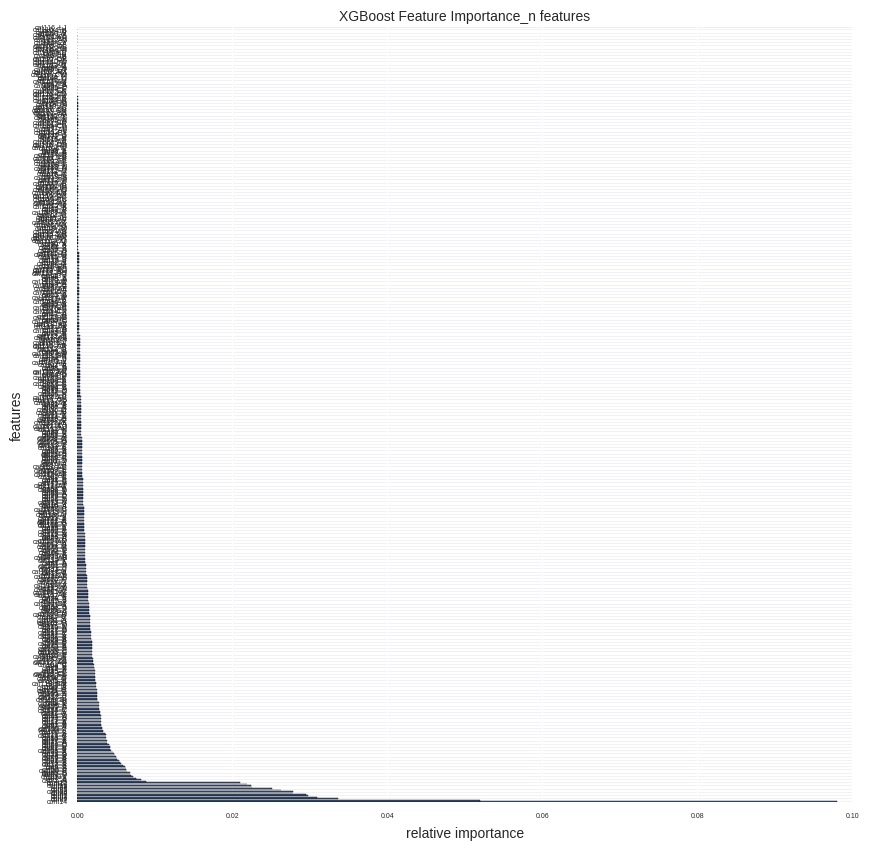

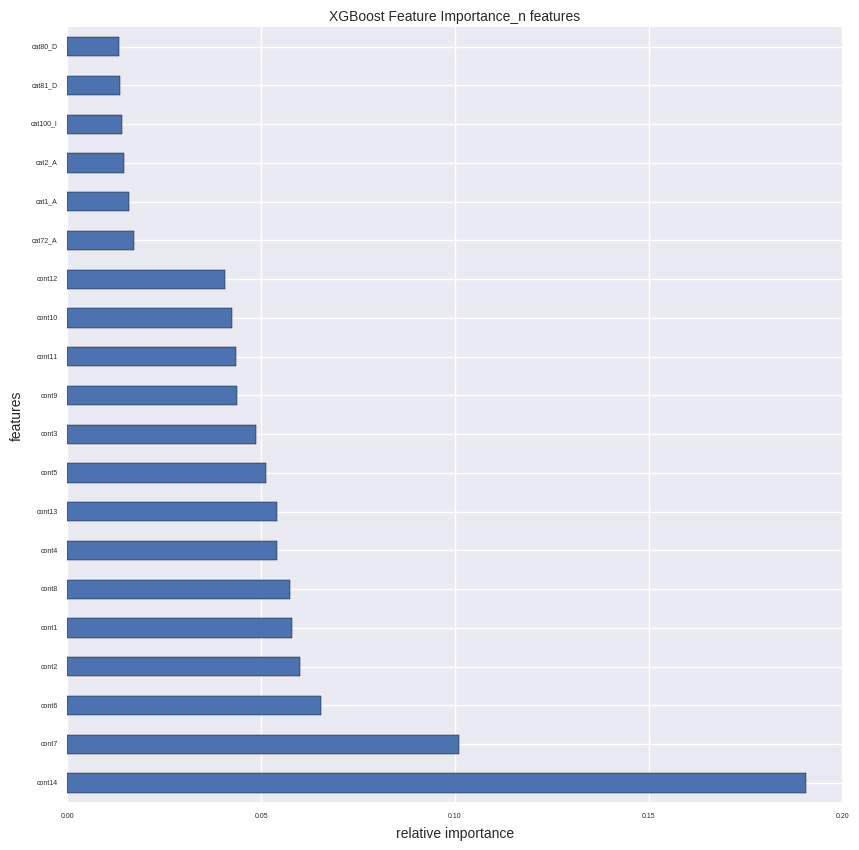

In [25]:
def plot_feature(n):
    data = importance_df.iloc[:n,:]
    data['fscore'] = data['fscore'] / data['fscore'].sum()
    data.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 10),fontsize=5)
    plt.title('XGBoost Feature Importance_n features',fontsize=10)
    plt.xlabel('relative importance',fontsize=10)
    plt.ylabel('features',fontsize=10)
    
plot_feature(1000)
plot_feature(20)

In [28]:
importance_df.to_csv('features_importance.csv', index = True)